In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import keras
from keras.preprocessing import image
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import *
import visualkeras
from numpy.random import *
from numpy import *

In [3]:
img_size = (32,32)

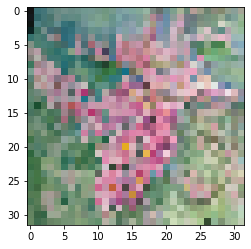

In [4]:
def list_file_in_path(img_size=img_size):
    img_path = './Art_Bangkok/WaterColor'
    import os
    file_list = []
    for root, dirs, files in os.walk(img_path):
        for file in files:
            tmp_file = cv2.imread(os.path.join(root, file))
            tmp_file = cv2.resize(tmp_file , img_size, interpolation=cv2.INTER_LINEAR)
            tmp_file = cv2.cvtColor(tmp_file, cv2.COLOR_BGR2RGB)
            file_list.append(tmp_file)
    return file_list

all_image = list_file_in_path()
train_dataset = list_file_in_path()
train_dataset = np.array(train_dataset) / 255.0
def generate_real_samples(dataset, n_samples):
    dataset = np.array(dataset)
    ix = randint(0,  dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

x_real, y_real = generate_real_samples(train_dataset, 100)
plt.imshow(x_real[0])

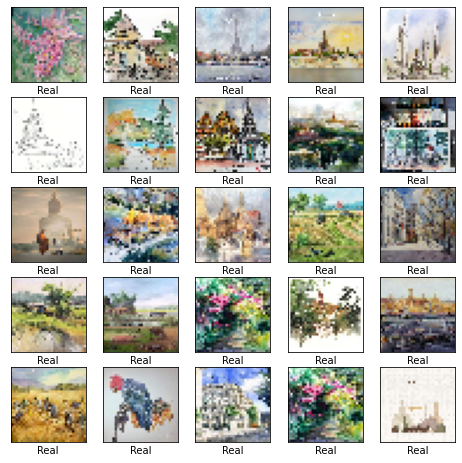

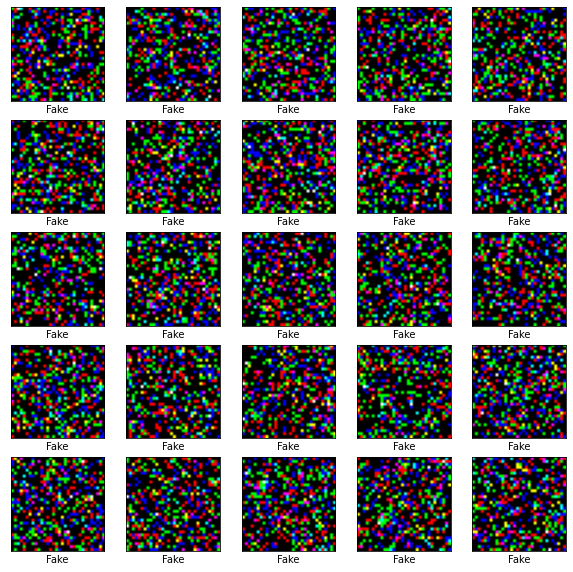

In [5]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

def test_generate_fake_samples(n_samples,target_size=img_size):
    hwc = (target_size[0],target_size[1],3)
    X = randn(n_samples, *hwc).astype(np.uint8)
    y = zeros((n_samples, 1))
    return X, y

x_fake, y_fake = test_generate_fake_samples(100)
# View Training Images and Validation Images

def show_all_image():
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_real[i], cmap=plt.cm.binary)
        plt.xlabel('Real')
    plt.show()
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_fake[i], cmap=plt.cm.binary)
        plt.xlabel('Fake')
    plt.show()

show_all_image()

In [6]:
def define_discriminator(input_shape = (img_size[0],img_size[1],3)):
      # DEFINE MODEL
    model = Sequential()
    #normal
    model.add(Conv2D(3,(1,1),strides=(1,1),padding='same',input_shape= (input_shape)))
    model.add(Activation(LeakyReLU(0.2)))
    #down
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(Activation(LeakyReLU(0.2)))
    #down
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(Activation(LeakyReLU(0.2)))
    #down
    model.add(Conv2D(256,(3,3),strides=(2,2),padding='same'))
    model.add(Activation(LeakyReLU(0.2)))
    #classifier
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    # COMPILE MODEL
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [7]:
def train_discriminator(model,x_real,x_fake,y_real,y_fake,epochs=10,batch_size=128):
    # TRAIN MODEL
    d_loss = []
    d_acc = []
    for epoch in range(epochs):
        # TRAIN DISCRIMINATOR
        # REAL DATA
        idx = np.random.randint(0, x_real.shape[0], batch_size)
        real_images = x_real[idx]
        real_labels = y_real[idx]
        d_loss_real, d_acc_real = model.train_on_batch(real_images, real_labels)
        # FAKE DATA
        idx = np.random.randint(0, x_fake.shape[0], batch_size)
        fake_images = x_fake[idx]
        fake_labels = y_fake[idx]
        d_loss_fake, d_acc_fake = model.train_on_batch(fake_images, fake_labels)
        # AVERAGE LOSS AND ACCURACY
        d_loss.append((d_loss_real + d_loss_fake) / 2)
        d_acc.append((d_acc_real + d_acc_fake) / 2)
        print('>%d, d_loss=%.3f, d_acc=%.3f' % (epoch + 1, d_loss[-1], d_acc[-1]))
    return d_loss, d_acc

In [8]:
d_model = define_discriminator()
d_model.summary()
train_discriminator(d_model,x_real,x_fake,y_real,y_fake,batch_size=128)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 3)         12        
                                                                 
 activation (Activation)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       3584      
                                                                 
 activation_1 (Activation)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 activation_2 (Activation)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

C:\Users\SHIBASAN\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, d_loss=6.720, d_acc=0.109
>2, d_loss=0.370, d_acc=0.723
>3, d_loss=0.381, d_acc=0.500
>4, d_loss=0.390, d_acc=0.500
>5, d_loss=0.386, d_acc=0.504
>6, d_loss=0.384, d_acc=0.504
>7, d_loss=0.382, d_acc=0.504
>8, d_loss=0.376, d_acc=0.512
>9, d_loss=0.373, d_acc=0.512
>10, d_loss=0.367, d_acc=0.512


([6.720116913318634,
  0.36975476518273354,
  0.380569331580773,
  0.38982119169509133,
  0.3864921456825341,
  0.38431203487562016,
  0.3816798072407437,
  0.37631120752485003,
  0.3730852256412618,
  0.3667808100944967],
 [0.109375,
  0.72265625,
  0.5,
  0.5,
  0.50390625,
  0.50390625,
  0.50390625,
  0.51171875,
  0.51171875,
  0.51171875])

In [9]:
def define_generator(latent_dim,disc_output_shape=(256,4,4)):
    model = Sequential()
    # foundation for 4x4 image
    c,w,h = disc_output_shape
    n_nodes = c*w*h
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((w, h, c)))
    # upsample
    model.add(Conv2DTranspose(128, (w, h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample
    model.add(Conv2DTranspose(128, (w, h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample
    model.add(Conv2DTranspose(128, (w, h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

g_model = define_generator(latent_dim=100)
g_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

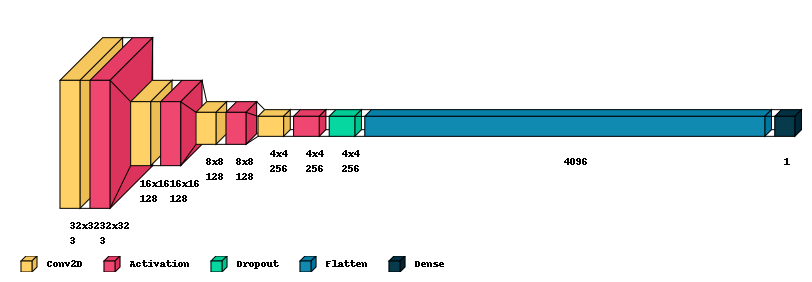

In [10]:
visualkeras.layered_view(d_model,draw_shapes=1,legend=True,padding_left=50,padding_vertical=75)

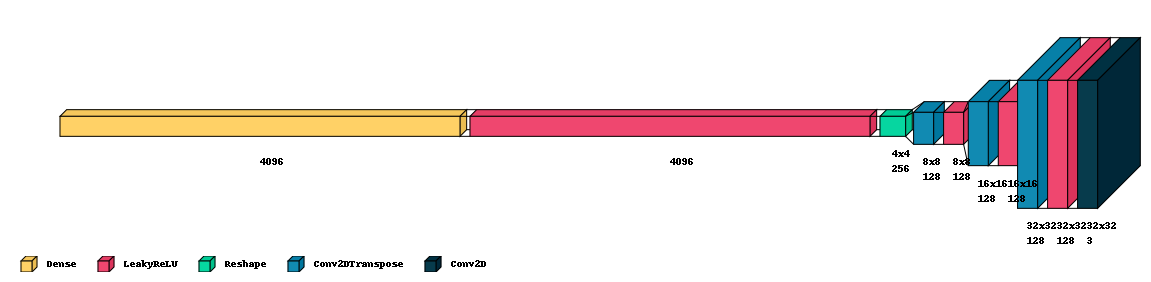

In [11]:
visualkeras.layered_view(g_model,draw_shapes=1,legend=True,padding_left=50,padding_vertical=75)

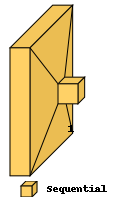

In [12]:
gan_model_view = Sequential()
gan_model_view.add(g_model)
gan_model_view.add(d_model)
visualkeras.layered_view(gan_model_view,draw_shapes=1,legend=True)

In [13]:
def define_gan(g_model, d_model, image_shape=(img_size[0],img_size[1],3)):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [14]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def train(g_model, d_model, gan_model, dataset, latent_dim,n_batch=128,n_epochs=50):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    d_loss1 = 0
    d_loss2 = 0
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
        # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator✬s error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this epoch
        print('>%d, discriminator_Loss=%.3f, generator_Loss=%.3f' % (i+1, d_loss1, d_loss2))
        # evaluate the model performance, sometimes
        if (i+1) % 1000 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [15]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    print(X_real.shape, y_real.shape)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save the generator model tile file
    filename = './Saved_model/generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [16]:
gan_model = define_gan(g_model, d_model)
gan_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential (Sequential)     (None, 1)                 450445    
                                                                 
Total params: 1,916,560
Trainable params: 1,466,115
Non-trainable params: 450,445
_________________________________________________________________


In [17]:
train(g_model, d_model, gan_model, train_dataset, latent_dim=100,n_epochs=100)

>1, discriminator_Loss=0.723, generator_Loss=0.706
>2, discriminator_Loss=0.717, generator_Loss=0.706
>3, discriminator_Loss=0.707, generator_Loss=0.706
>4, discriminator_Loss=0.703, generator_Loss=0.707
>5, discriminator_Loss=0.695, generator_Loss=0.709
>6, discriminator_Loss=0.691, generator_Loss=0.711
>7, discriminator_Loss=0.681, generator_Loss=0.715
>8, discriminator_Loss=0.675, generator_Loss=0.720
>9, discriminator_Loss=0.673, generator_Loss=0.726
>10, discriminator_Loss=0.657, generator_Loss=0.737
>11, discriminator_Loss=0.653, generator_Loss=0.747
>12, discriminator_Loss=0.651, generator_Loss=0.760
>13, discriminator_Loss=0.643, generator_Loss=0.773
>14, discriminator_Loss=0.638, generator_Loss=0.782
>15, discriminator_Loss=0.642, generator_Loss=0.789
>16, discriminator_Loss=0.644, generator_Loss=0.795
>17, discriminator_Loss=0.642, generator_Loss=0.792
>18, discriminator_Loss=0.647, generator_Loss=0.790
>19, discriminator_Loss=0.644, generator_Loss=0.787
>20, discriminator_Lo

In [18]:
X = g_model.predict(generate_latent_points(100,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

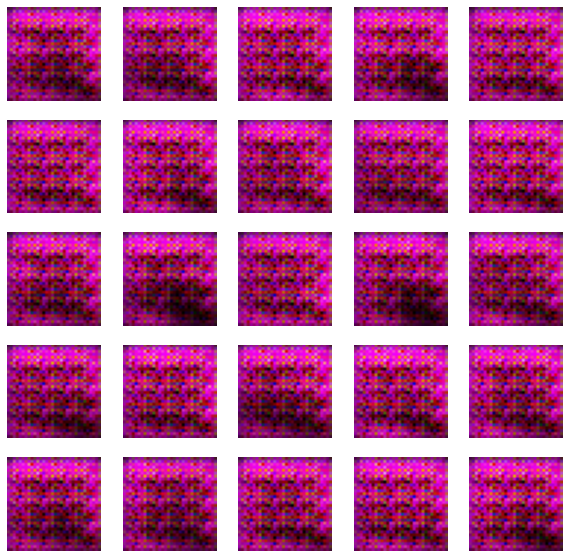

In [19]:
# plot the result
def plot_all_image():
    plt.figure(figsize=(10,10))
    for i in range(25):
        X = g_model.predict(generate_latent_points(100,1))
        plt.subplot(5,5,i+1)
        plt.imshow(X[0,:,:,:])
        plt.axis('off')
    plt.show()
plot_all_image()

In [20]:
loaded_model = tf.keras.models.load_model('./Saved_model/generator_model_3000.h5')

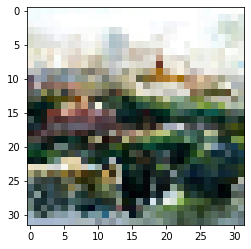

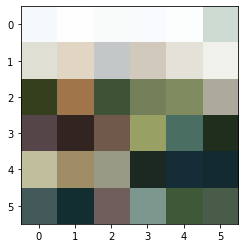

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


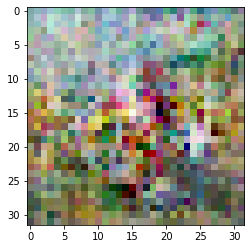

In [21]:
pick_img = x_real[8]
real_im_test = cv2.resize(pick_img,(6,6))
plt.imshow(pick_img)
plt.show()
plt.imshow(real_im_test)
plt.show()
real_im_test = np.array(real_im_test)
real_im_test = real_im_test.reshape(real_im_test[0].shape[0]*real_im_test[1].shape[0]*3)
real_im_test = real_im_test[0:100]
real_im_test = real_im_test.reshape(1,100)
pred = loaded_model.predict(real_im_test)
plt.imshow(pred[0,:,:,:])